In [ ]:
from os import listdir
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sys
sys.path.append("./python")
from MRIDataset import SampleMapper, MRIDataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.optim as optim
import torch
import torchvision

In [2]:
# =============================================
# Training routine
# =============================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cuda'):
    """
    Train the model

    Returns:
        train_losses, val_losses, train_accs, val_accs
    """
    model = model.to(device)

    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    best_val_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_correct += ((outputs > 0.5).float() == labels).sum()
            train_total += labels.size(0)
            running_loss += loss.item()

        train_accuracy = train_correct / train_total
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_correct += ((outputs > 0.5).float() == labels).sum()
                val_total += labels.size(0)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()


        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Train accuracy: {train_accuracy*100:.2f}%")
        print(f"  Val accuracy: {val_accuracy*100:.2f}%")

    return train_losses, val_losses, train_acc, val_acc, best_model

In [3]:
# Construct patient list and related tumor grade
data_dir = "../data"
full_patient_list = []
for patient in listdir(data_dir):
    if "FU" in patient:
        continue
    full_patient_list.append(patient.replace("_nifti", ""))

tumor_grade = []
meta_data = pd.read_csv("../processed-data/UCSF-PDGM-metadata_v5.csv")
meta_data["ID"] = meta_data["ID"].apply(lambda x: "-".join(x.split("-")[:-1]) + "-" + x.split("-")[-1].rjust(4, "0"))
grade_key = "WHO CNS Grade"
for patient_id in full_patient_list:
    grade = meta_data[grade_key].loc[meta_data["ID"] == patient_id]
    tumor_grade.append(grade.values[0])
print(len(full_patient_list), len(tumor_grade))

495 495


In [4]:
data_dir = "../processed-data/images"
modality = "FLAIR"
full_sample_map = SampleMapper(data_dir,
                               modality)

In [5]:
# Check that the splits are properly stratified with respect to tumor class.
train_patients, test_patients, train_tumor, test_tumor = train_test_split(full_patient_list, tumor_grade, test_size=0.2, random_state=360, stratify=tumor_grade)
print("N training patients:", len(train_patients))
print("N test patients:", len(test_patients))
print("N train tumor grade:", len(train_tumor))
classes, counts = np.unique(train_tumor, return_counts=True)
print("\tTraining tumor classes:", classes)
print("\tTraining tumor class proportion:", counts/counts.sum())
print("N test tumor grade:", len(test_tumor))
classes, counts = np.unique(test_tumor, return_counts=True)
print("\tTest tumor classes:", classes) 
print("\tTest tumor class proportion:", counts/counts.sum())

N training patients: 396
N test patients: 99
N train tumor grade: 396
	Training tumor classes: [2 3 4]
	Training tumor class proportion: [0.11363636 0.08585859 0.80050505]
N test tumor grade: 99
	Test tumor classes: [2 3 4]
	Test tumor class proportion: [0.11111111 0.09090909 0.7979798 ]


In [ ]:
import time

full_data_map = full_sample_map.data_map

## Separate the training data into 4 batches for 4Fold Cross validation.
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=360)

# DataLoader parameters
batch_size = 32

n_epochs = 5
models = []
loss = {}
acc = {}

best_model_params = {}

# Transforms to perform after PIL to tensor, resizing, and ToDType(float32) automatically performed by the dataset.
resnet_weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
preprocessing = resnet_weights.transforms()

start_time = time.time()
for i, (train_indices, validation_indices) in enumerate(skf.split(train_patients, train_tumor)):
    # Multiple slices are taken from the MRI of a single patient_id. 
    # Dataset indices for these slices are pulled from the get_indices_from_patient_list method.
    print("Currently running through fold", i)

    training_patients = np.array(train_patients)[train_indices]
    validation_patients = np.array(train_patients)[validation_indices]

    training_data_map = full_data_map.loc[full_data_map["patient_id"].isin(training_patients)]
    validation_data_map = full_data_map.loc[full_data_map["patient_id"].isin(validation_patients)]

    print("Loading the training dataset...")
    load_start_time = time.time()
    training_dataset = MRIDataset(training_data_map,
                                                 pre_transforms=[preprocessing],
                                                 to_rgb=True)
    print("Finished loading the training dataset!")
    print(f"Time to load: {(time.time() - load_start_time)/60:.2f} minutes")
    load_start_time = time.time()
    print("Loading the validation dataset...")
    validation_dataset = MRIDataset(validation_data_map,
                                                   pre_transforms=[preprocessing],
                                                   to_rgb=True)
    print("Finished loading the validation dataset!")
    print(f"Time to load: {(time.time() - load_start_time)/60:.2f} minutes")
    print("N training samples:", len(training_dataset))
    print("N validation samples:" , len(validation_dataset))

    print("Building dataloaders...")
    training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    print("Building model and setting the criterion.")
    # Use a resnet model
    model = torchvision.models.resnet18(weights=resnet_weights)
    model_fc_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(model_fc_features, 1024), nn.ReLU(), nn.Dropout(0.5), nn.Linear(1024,1), nn.Sigmoid())
    indices_of_final_res_block_and_fx_layers = [9, 10]
    # Freeze the parameters of all but the final classification layer and the final residual layer.
    for index, child in enumerate(model.children()):
        if index not in indices_of_final_res_block_and_fx_layers:
            for param in child.parameters():
                param.requires_grad = False

    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print("Training!")
    load_start_time = time.time()
    train_losses, val_losses, train_acc, val_acc, top_acc_model = train_model(
        model, training_loader, validation_loader, criterion, optimizer,
        num_epochs=n_epochs, device=device
    )
    print("Finished training!")
    print("Time to train:", (time.time() - load_start_time) / 60, "minutes")
    print("Losses:")
    print("\tTraining:", train_losses)
    print("\tValidation:", val_losses)
    print("Accuracy:")
    print("\tTraining:", train_acc)
    print("\tValidation:", val_acc)
    loss[i] = [train_losses, val_losses]
    acc[i] = [train_acc, val_acc]
    best_model_params[i] = top_acc_model
    models.append(model)


Currently running through fold 0
Loading the training dataset...
Finished loading the training dataset!
Time to load: 0.00 minutes
Loading the validation dataset...
Finished loading the validation dataset!
Time to load: 0.00 minutes
N training samples: 7127
N validation samples: 2371
Building dataloaders...
Building model and setting the criterion.
Training!
Epoch 1/5
  Train Loss: 0.5626
  Val Loss: 0.4801
  Train accuracy: 71.63%
  Val accuracy: 76.80%
Epoch 2/5
  Train Loss: 0.4715
  Val Loss: 0.5076
  Train accuracy: 77.19%
  Val accuracy: 76.21%
Epoch 3/5
  Train Loss: 0.4618
  Val Loss: 0.4881
  Train accuracy: 78.20%
  Val accuracy: 76.59%
Epoch 4/5
  Train Loss: 0.4464
  Val Loss: 0.4776
  Train accuracy: 79.15%
  Val accuracy: 77.48%
Epoch 5/5
  Train Loss: 0.4326
  Val Loss: 0.4490
  Train accuracy: 79.98%
  Val accuracy: 78.95%
Finished training!
Time to train: 40.71418334245682 minutes
Losses:
	Training: [0.5625924345089182, 0.4714622450115435, 0.4618358236524556, 0.4464211

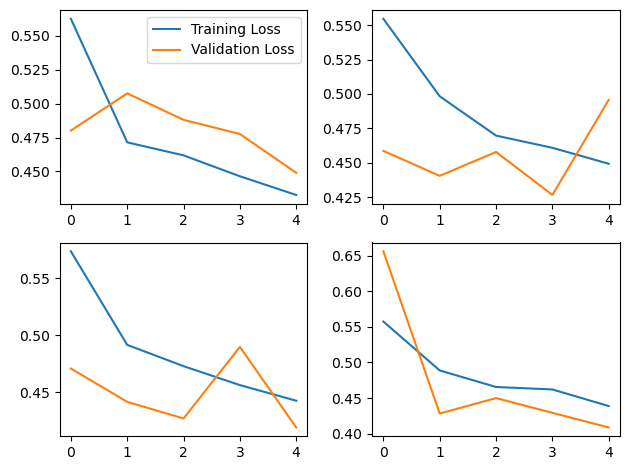

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flatten()):
    _x = loss[i][0]
    _y = loss[i][1]
    ax.plot(range(len(_x)),_x, label="Training Loss")
    ax.plot(range(len(_y)),_y, label="Validation Loss")
    with open(f"loss_for_fold{i}_5epoch_resnet_freeze_final_layer_with_dropout_models_FLAIR_new.txt", "w") as f:
        f.write("train_loss, val_loss\n")
        for index, train_loss in enumerate(loss[i][0]):
            val_loss = loss[i][1][index]
            f.write(f"{train_loss},{val_loss}\n")
axes[0][0].legend()
fig.tight_layout()
fig.savefig("losses_5epoch_resnet_freeze_with_dropout_new.png")

In [ ]:
# Save models
for i, model_params in best_model_params.items():
    path = f"../models/model_fold{i}_resnet_FLAIR.pth"
    torch.save(model_params, path)